In [82]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sympy
%matplotlib inline

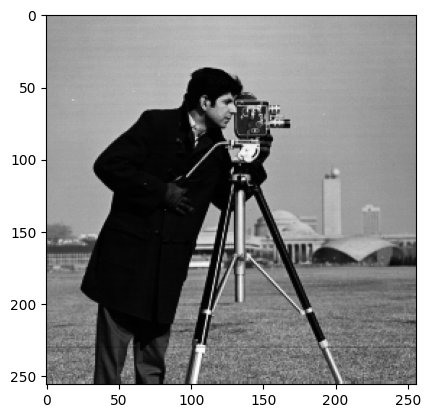

In [83]:
# Load the .mat file into a dictionary
mat_data = scipy.io.loadmat('SampleImages/camera256.mat')

# Extract the image data from the dictionary
image_data = mat_data['camera256']

image_data = image_data.astype(np.int16)

# Display the image using Matplotlib
plt.imshow(image_data, cmap='gray')
plt.axis('on')
plt.show()


In [84]:
# Separate image into 8x8 blocks
block_size = 8
blocks = []
for i in range(0, image_data.shape[0], block_size):
    for j in range(0, image_data.shape[1], block_size):
        blocks.append(image_data[i:i+block_size, j:j+block_size])

# Convert blocks to numpy array
print(blocks[589])
blocks = np.array(blocks)
blocks = blocks - 128

print(blocks.shape)
print(blocks[589])

[[ 14  12  12  12  62 173 168 167]
 [ 13  13  15  15 135 170 162 163]
 [ 13  13  13  21 170 166 162 164]
 [ 13  13  13  82 170 162 161 171]
 [ 13  12  14 157 168 162 176 185]
 [ 14  15  48 174 165 160 171 177]
 [ 14  13 111 173 154 136 135 135]
 [ 13  30 181 189 187 182 184 182]]
(1024, 8, 8)
[[-114 -116 -116 -116  -66   45   40   39]
 [-115 -115 -113 -113    7   42   34   35]
 [-115 -115 -115 -107   42   38   34   36]
 [-115 -115 -115  -46   42   34   33   43]
 [-115 -116 -114   29   40   34   48   57]
 [-114 -113  -80   46   37   32   43   49]
 [-114 -115  -17   45   26    8    7    7]
 [-115  -98   53   61   59   54   56   54]]


In [85]:
#Apply 2 dimensional DCT to each block

dct_blocks = []
for i in range(blocks.shape[0]):
    dct_blocks.append(scipy.fftpack.dctn(blocks[i], norm='ortho'))
dct_blocks = np.array(dct_blocks)

print(dct_blocks.shape)
print(dct_blocks[589])

(1024, 8, 8)
[[-1.93625000e+02 -4.92723058e+02 -1.14022341e+02  5.43378750e+01
   4.08750000e+01 -1.98546268e+00  5.96339723e+00  9.39436792e+00]
 [-1.42093268e+02 -5.65151569e+01  1.45577365e+02  1.09080600e+02
  -4.93996723e+01 -6.56382950e+01  3.84838271e-02  8.65106699e+00]
 [ 9.65794896e+00  3.38028383e+01  9.08102903e+00 -4.29426300e+01
  -6.60898740e+01  2.02349126e+01  5.36064168e+01  1.65741818e+01]
 [-2.61872498e+01 -3.10378340e+00  1.69860904e+01 -8.35049854e+00
   1.69032830e+01  3.73883094e+01 -1.78420670e+01 -5.67820973e+01]
 [ 2.96250000e+01 -1.65108919e+01  6.80822058e+00 -1.50661328e+01
  -8.37500000e+00  1.47289982e+01  4.35079103e+00 -1.61484118e+01]
 [-4.17394441e+01  2.56552033e+01  6.71693438e+00 -3.37457205e-01
  -5.06568264e+00  1.37956597e+00  6.72898703e+00  4.44488802e-02]
 [ 2.10298662e+01 -1.98977732e+01  9.85641681e+00  2.75472423e+00
  -7.66712536e+00 -2.32133875e+00  4.18970965e-01  9.32716863e-01]
 [-1.20462641e+01  6.42530042e+00 -2.22585084e-01 -5.099

In [86]:
# Quantize the DCT coefficients

quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])

quality_factor = 5

if quality_factor > 50:
    scale = (100 - quality_factor) / 50
    quantization_matrix = quantization_matrix * scale
else:
    scale = quality_factor / 50
    quantization_matrix = quantization_matrix * scale

quantized_dct_blocks = []


for x in dct_blocks:
    s = np.zeros((8, 8))
    for i in range(8):
        for j in range(8):
            s[i][j] = round(x[i][j] / quantization_matrix[i][j])
    quantized_dct_blocks.append(s)

quantized_dct_blocks = np.array(quantized_dct_blocks)

print(quantized_dct_blocks[589])


[[-121. -448. -114.   34.   17.    0.    1.    2.]
 [-118.  -47.  104.   57.  -19.  -11.    0.    2.]
 [   7.   26.    6.  -18.  -17.    4.    8.    3.]
 [ -19.   -2.    8.   -3.    3.    4.   -2.   -9.]
 [  16.   -8.    2.   -3.   -1.    1.    0.   -2.]
 [ -17.    7.    1.    0.   -1.    0.    1.    0.]
 [   4.   -3.    1.    0.   -1.    0.    0.    0.]
 [  -2.    1.    0.    0.    0.    0.    0.    0.]]


In [87]:
# Coding the DC coefficients

dc_coefficients = []
for x in quantized_dct_blocks:
    dc_coefficients.append(x[0][0])

# print(dc_coefficients)

# differential pulse code modulation for DC coefficients

dpcm_dc_coefficients = []
dpcm_dc_coefficients.append(dc_coefficients[0])
for i in range(1, len(dc_coefficients)):
    dpcm_dc_coefficients.append(dc_coefficients[i] - dc_coefficients[i-1])

# print(dpcm_dc_coefficients)

# run,level modulation for AC pairs

run_level_pairs_blocks = []

for x in quantized_dct_blocks:
    run = 0
    level = 0
    run_level_pairs = []
    for i in range(1, 8):
        for j in range(1, 8):
            if x[i][j] != 0:
                run_level_pairs.append((run, level))
                run = 0
                level = x[i][j]
            else:
                run += 1
                
    run_level_pairs_blocks.append(run_level_pairs)

    # Entropy coding for run-level pairs

entropy_coded_blocks = []

for x in run_level_pairs_blocks:
    entropy_coded_block = []
    for i in range(len(x)):
        if i == 0:
            entropy_coded_block.append((x[i][0], x[i][1]))
        else:
            if x[i][0] == 0 and x[i][1] == 0:
                entropy_coded_block.append((15, 0))
            else:
                entropy_coded_block.append((x[i][0], x[i][1]))
    entropy_coded_blocks.append(entropy_coded_block)


In [88]:
# inverse quantization

inverse_quantized_dct_blocks = []

for x in quantized_dct_blocks:
    s = np.zeros((8, 8))
    for i in range(8):
        for j in range(8):
            s[i][j] = x[i][j] * quantization_matrix[i][j]
    inverse_quantized_dct_blocks.append(s)

inverse_quantized_dct_blocks = np.array(inverse_quantized_dct_blocks)

print(inverse_quantized_dct_blocks.shape)
print(inverse_quantized_dct_blocks[589])

# perform inverse DCT

inverse_dct_blocks = []

for x in inverse_quantized_dct_blocks:
    inverse_dct_blocks.append(scipy.fftpack.idctn(x, norm='ortho'))
inverse_dct_blocks = np.array(inverse_dct_blocks)

print(inverse_dct_blocks.shape)
print(inverse_dct_blocks[589])

inverse_dct_blocks = inverse_dct_blocks + 128
inverse_dct_blocks = inverse_dct_blocks.astype(int)

print(inverse_dct_blocks.shape)
print(inverse_dct_blocks[589])



(1024, 8, 8)
[[-193.6 -492.8 -114.    54.4   40.8    0.     5.1   12.2]
 [-141.6  -56.4  145.6  108.3  -49.4  -63.8    0.    11. ]
 [   9.8   33.8    9.6  -43.2  -68.    22.8   55.2   16.8]
 [ -26.6   -3.4   17.6   -8.7   15.3   34.8  -16.   -55.8]
 [  28.8  -17.6    7.4  -16.8   -6.8   10.9    0.   -15.4]
 [ -40.8   24.5    5.5    0.    -8.1    0.    11.3    0. ]
 [  19.6  -19.2    7.8    0.   -10.3    0.     0.     0. ]
 [ -14.4    9.2    0.     0.     0.     0.     0.     0. ]]
(1024, 8, 8)
[[-115.42989944 -116.50672612 -112.89437464 -118.20206432  -66.29889342
    44.37205111   41.13551185   38.72371711]
 [-111.39142102 -117.30550093 -113.68402361 -111.48974096    7.52600978
    40.26979365   37.14647476   34.96366728]
 [-114.91377797 -116.18751392 -112.55720432 -106.44526442   40.51416428
    37.77216866   34.3138256    32.86006485]
 [-115.31724655 -115.45261776 -116.36317821  -44.7177498    44.5817576
    33.26246883   34.73961489   44.88497335]
 [-115.49031454 -113.47001164 -116

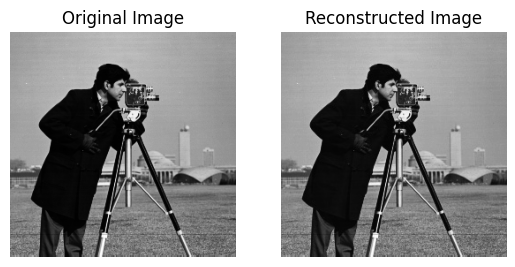

In [89]:
num_blocks = int(np.sqrt(inverse_dct_blocks.shape[0]))
block_size = inverse_dct_blocks.shape[1]

# Reshape the blocks array
blocks_reshaped = inverse_dct_blocks.reshape((num_blocks, num_blocks, block_size, block_size))

# Initialize an empty image
reconstructed_image = np.zeros((num_blocks * block_size, num_blocks * block_size))

# Reconstruct the image from blocks
for i in range(num_blocks):
    for j in range(num_blocks):
        reconstructed_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = blocks_reshaped[i, j, :, :]

# Visualize the images
fig,ax = plt.subplots(1,2)
ax[0].imshow(image_data, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(reconstructed_image, cmap='gray')
ax[1].set_title('Reconstructed Image')
ax[1].axis('off')
plt.show()




In [90]:
# find percentage of zeroes
num_zeroes = 0
for x in quantized_dct_blocks:
    for i in range(8):
        for j in range(8):
            if x[i][j] == 0:
                num_zeroes += 1
                
percentage_zeroes = num_zeroes / (quantized_dct_blocks.shape[0] * 64) * 100
print("Percentage of Zeroes : ",percentage_zeroes)

# two dimensional mean square error
error_matrix = image_data - reconstructed_image
mse = np.mean(np.square(error_matrix))
print("Mean Square Error : ",mse)

# calculate the peak signal to noise ratio  
psnr = 20 * np.log10((255) / mse)
print("Peak Signal to Noise Ratio (PSNR) : ",psnr)


Percentage of Zeroes :  51.3427734375
Mean Square Error :  2.7506866455078125
Peak Signal to Noise Ratio (PSNR) :  39.34198122929713
